In [35]:
import test_config as cfg
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import os, os.path
import pickle
import io

import skimage
import skimage.io, skimage.transform, skimage.filters
import scipy.ndimage

import sys
sys.path.append(r'../src/')

import importlib
import transform
import filters
import local_radon
importlib.reload(transform)
importlib.reload(filters)
importlib.reload(local_radon)

<module 'local_radon' from '../src\\local_radon.py'>

In [65]:
def select_best_local_minima(minimas, angles, min_angle, max_value, max_split_pct, min_split_abs):
    tmp = [x for x in minimas if abs(angles[x[0]])>min_angle and x[2]<max_value
           and min(x[3], x[4]) >= min_split_abs and min(x[3], x[4]) < max_split_pct * (x[3] + x[4])]
    if len(tmp) == 0:
        return None
    return sorted(tmp, key=lambda x: x[2])[0]


def find_best_vlines(src, min_angle, num_angles, window_size_1d, max_value, zero_threshold, min_split_abs, max_split_pct):
    theta = np.append(np.linspace(-np.pi/2, -min_angle, num_angles//2+1)[:-1], np.linspace(min_angle, np.pi/2, num_angles//2+1))
    grid = local_radon.create_grid(src, theta)
    
    
    tmp = np.copy(src)
    res = []
    
    while True:
        gradon = local_radon.calc_local_radon(grid, tmp, 0, tmp.shape[0], 0, tmp.shape[1])
        
        mins = local_radon.get_local_minimas_2d(gradon, window_size_1d, max_value, zero_threshold)
        tres = select_best_local_minima(mins, theta, min_angle, max_value, min_split_abs, max_split_pct)
        if tres is None:
            return res

        off = local_radon.global_offset_from_subgrid(grid, 0, tmp.shape[0], 0, tmp.shape[1], tres[0], tres[1])
        ang = theta[tres[0]]
        
        if tres[3] > tres[4]:
            tmp[grid[:,:,tres[0]]>off] = False
        else:
            tmp[grid[:,:,tres[0]]<off] = False
            
        res.append((ang, off, tres[2], tres[3], tres[4]))
        
    return None

def calc_j_point(i, alfa, offset):
    return (offset - i*np.cos(alfa))/np.sin(alfa)

def calc_i_point(j, alfa, offset):
    return (offset - j*np.sin(alfa))/np.cos(alfa)

def calc_2points(alfa, offset, sz):
    res = []
    p1_i = calc_i_point(0, alfa, offset)
    if p1_i >= 0 and p1_i < sz[0]:
        res.append((p1_i, 0))
    p2_i = calc_i_point(sz[1]-1, alfa, offset)
    if p2_i >= 0 and p2_i < sz[0]:
        res.append((p2_i, sz[1]-1))
    p3_j = calc_j_point(0, alfa, offset)
    if p3_j >= 0 and p3_j < sz[1]:
        res.append((0, p3_j))
    p4_j = calc_j_point(sz[0]-1, alfa, offset)
    if p4_j >= 0 and p4_j < sz[1]:
        res.append((sz[0]-1, p4_j))
    return res

def erase_data(src, alfa, offset, direction):
    res = np.copy(src)
    grid = np.array([[(i*np.cos(alfa)+j*np.sin(alfa)-offset) for j in range(src.shape[1])] for i in range(src.shape[0])])
    res[grid*direction > 0] = 0
    return res

D:/Data/bujo_sample\20190309_125153.jpg


C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


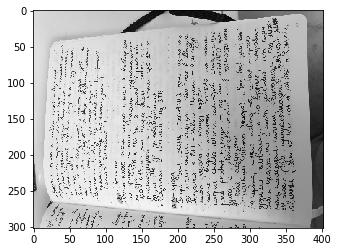

In [166]:
src_fname = os.path.join(cfg.sample_path, os.listdir(cfg.sample_path)[7])
print(src_fname)
src = skimage.io.imread(src_fname, as_grey=True)

src2 = skimage.transform.rescale(src, scale=0.1)
plt.imshow(src2, cmap='gray')

C:\Anaconda3\lib\site-packages\skimage\transform\radon_transform.py:69: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


Text angles is 1.1166253101737027


C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Text line delta is 18
Wall time: 2.34 s


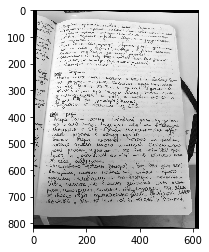

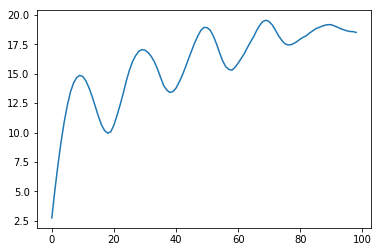

In [167]:
%%time
text_angle = transform.get_text_angle(src2)
print('Text angles is {}'.format(text_angle[0][0]))

src3 = skimage.transform.rotate(skimage.transform.rescale(src, scale=0.2), -90.0-text_angle[0][0], resize=True)
srcr = skimage.transform.rotate(src, -90.0-text_angle[0][0], resize=True)
plt.figure()
plt.imshow(src3, cmap='gray')

text_line_delta, text_line_deltas = transform.get_text_line_delta(src3)
plt.figure()
plt.plot(text_line_deltas)
print('Text line delta is {}'.format(text_line_delta))

Wall time: 299 ms


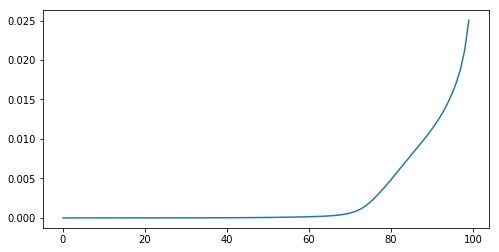

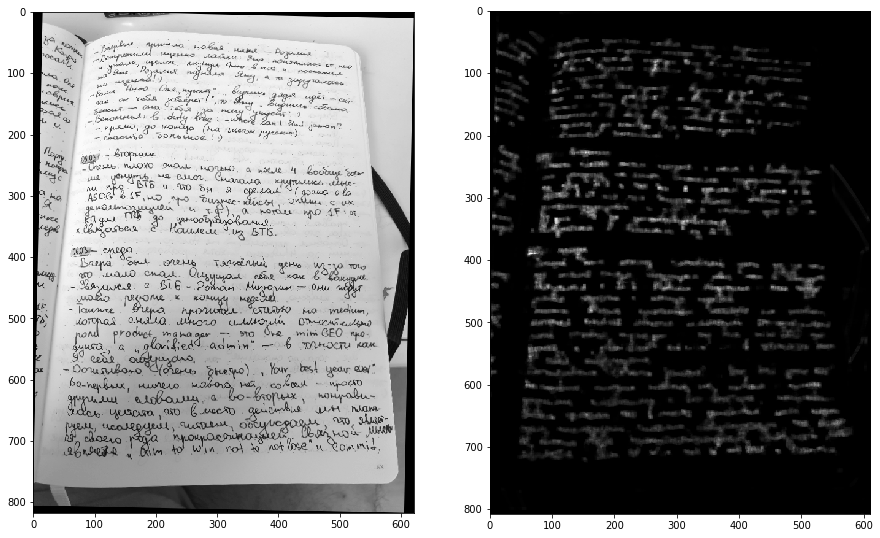

In [168]:
%%time
src4 = transform.filter_variance(src3, (9, 9), 50, 50)
text_cutoff = np.percentile(src4, 90)/2

plt.figure(figsize=(8,4))
plt.plot(np.percentile(src4, range(100)))

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(src3, cmap='gray')
plt.subplot(122)
plt.imshow(src4, cmap='gray')

C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


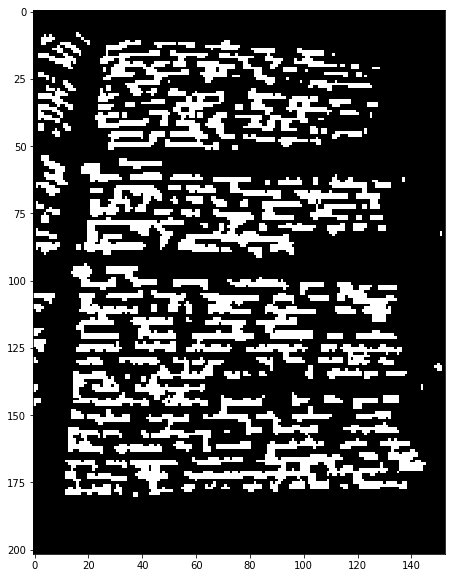

In [169]:
src5 = skimage.transform.rescale(src4>text_cutoff, scale=0.25)>0.0
src6 = skimage.filters.gaussian(src5, sigma=0.2)>0.4

plt.figure(figsize=(10,10))
plt.imshow(src6, cmap='gray')

In [170]:
%%time
res = find_best_vlines(src6, np.pi*3/8, num_angles=131, window_size_1d=15, max_value=2, zero_threshold=10, min_split_abs=100, max_split_pct=0.10)
print(res)

[(1.4016336454477538, 27.0, 0, 412, 6516)]
Wall time: 314 ms


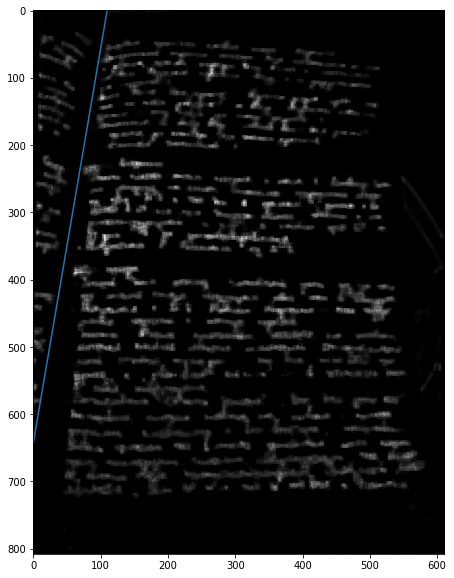

In [171]:
plt.figure(figsize=(10,10))
plt.imshow(src4, cmap='gray')
for (a, off, val, v_neg, v_pos) in res:
    pts = np.array(calc_2points(a, off, src6.shape))
    plt.plot(pts[:,1]*4,pts[:,0]*4)

Wall time: 2.33 s


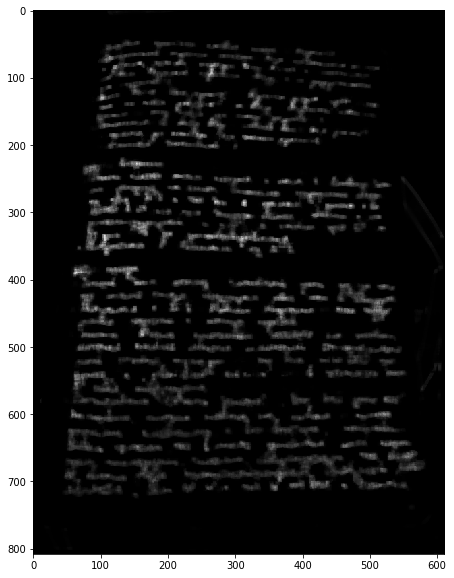

In [172]:
%%time
src7 = np.copy(src4)
for (a, off, val, v_neg, v_pos) in res:
    src7 = erase_data(src7, a, off*4, -1 if v_neg < v_pos else 1)
plt.figure(figsize=(10,10))    
plt.imshow(src7, cmap='gray')

In [165]:
3*np.pi/8, np.pi/4, np.pi*2/5

(1.1780972450961724, 0.7853981633974483, 1.2566370614359172)